<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/rl/actor-critic-agent-with-tensorflow2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning with TensorFlow 2.0

## Based on Code by Roman Ring: http://inoryy.com/post/tensorflow2-deep-reinforcement-learning/

## Notebook forked from: https://github.com/inoryy/tensorflow2-deep-reinforcement-learning/blob/master/actor-critic-agent-with-tensorflow2.ipynb

changes:
* GPU support enabled
* removed parts used for TF 2.0 experiments only (to concentrate on Reinforcement Learning)
* applying to Berater environment (wip)
  * TODO: increase capacity of network (look for Olli comment below)

# Setup

In [0]:
!pip install tf-nightly-2.0-preview >/dev/null

In [0]:
import gym
import logging
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kls
import tensorflow.keras.optimizers as ko

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [4]:
print("TensorFlow Ver: ", tf.__version__)
print("Eager Execution:", tf.executing_eagerly())

TensorFlow Ver:  2.0.0-dev20190203
Eager Execution: True


In [5]:
# eager by default!
print("1 + 2 + 3 + 4 + 5 =", tf.reduce_sum([1, 2, 3, 4, 5]))

1 + 2 + 3 + 4 + 5 = tf.Tensor(15, shape=(), dtype=int32)


# Advantage Actor-Critic with TensorFlow 2.0

## Policy & Value Model Class

In [0]:
class ProbabilityDistribution(tf.keras.Model):
    def call(self, logits):
        # sample a random categorical action from given logits
        return tf.squeeze(tf.random.categorical(logits, 1), axis=-1)

class Model(tf.keras.Model):
    def __init__(self, num_actions):
        super().__init__('mlp_policy')
        # no tf.get_variable(), just simple Keras API
        self.hidden1 = kl.Dense(128, activation='relu')
        self.hidden2 = kl.Dense(128, activation='relu')
        self.value = kl.Dense(1, name='value')
        # logits are unnormalized log probabilities
        self.logits = kl.Dense(num_actions, name='policy_logits')
        self.dist = ProbabilityDistribution()

    def call(self, inputs):
        # inputs is a numpy array, convert to Tensor
        x = tf.convert_to_tensor(inputs)
        # separate hidden layers from the same input tensor
        hidden_logs = self.hidden1(x)
        hidden_vals = self.hidden2(x)
        return self.logits(hidden_logs), self.value(hidden_vals)

    def action_value(self, obs):
        # executes call() under the hood
        logits, value = self.predict(obs)
        action = self.dist.predict(logits)
        # a simpler option, will become clear later why we don't use it
        # action = tf.random.categorical(logits, 1)
        return np.squeeze(action, axis=-1), np.squeeze(value, axis=-1)

## Advantage Actor-Critic Agent Class

In [0]:
class A2CAgent:
    def __init__(self, model):
        # hyperparameters for loss terms, gamma is the discount coefficient
        self.params = {
            'gamma': 0.99,
            'value': 0.5,
            'entropy': 0.0001
        }
        self.model = model
        self.model.compile(
            optimizer=ko.RMSprop(lr=0.0007),
            # define separate losses for policy logits and value estimate
            loss=[self._logits_loss, self._value_loss]
        )
    
    def train(self, env, batch_sz=32, updates=1000):
        # storage helpers for a single batch of data
        actions = np.empty((batch_sz,), dtype=np.int32)
        rewards, dones, values = np.empty((3, batch_sz))
        observations = np.empty((batch_sz,) + env.observation_space.shape)
        # training loop: collect samples, send to optimizer, repeat updates times
        ep_rews = [0.0]
        next_obs = env.reset()
        for update in range(updates):
            for step in range(batch_sz):
                observations[step] = next_obs.copy()
                actions[step], values[step] = self.model.action_value(next_obs[None, :])
                next_obs, rewards[step], dones[step], _ = env.step(actions[step])

                ep_rews[-1] += rewards[step]
                if dones[step]:
                    ep_rews.append(0.0)
                    next_obs = env.reset()
                    logging.info("Episode: %03d, Reward: %03d" % (len(ep_rews)-1, ep_rews[-2]))

            _, next_value = self.model.action_value(next_obs[None, :])
            returns, advs = self._returns_advantages(rewards, dones, values, next_value)
            # a trick to input actions and advantages through same API
            acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)
            # performs a full training step on the collected batch
            # note: no need to mess around with gradients, Keras API handles it
            losses = self.model.train_on_batch(observations, [acts_and_advs, returns])
            logging.debug("[%d/%d] Losses: %s" % (update+1, updates, losses))
        return ep_rews

    def test(self, env, render=False):
        obs, done, ep_reward = env.reset(), False, 0
        while not done:
            action, _ = self.model.action_value(obs[None, :])
            obs, reward, done, _ = env.step(action)
            ep_reward += reward
            if render:
                env.render()
        return ep_reward

    def _returns_advantages(self, rewards, dones, values, next_value):
        # next_value is the bootstrap value estimate of a future state (the critic)
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        # returns are calculated as discounted sum of future rewards
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.params['gamma'] * returns[t+1] * (1-dones[t])
        returns = returns[:-1]
        # advantages are returns - baseline, value estimates in our case
        advantages = returns - values
        return returns, advantages
    
    def _value_loss(self, returns, value):
        # value loss is typically MSE between value estimates and returns
        return self.params['value']*kls.mean_squared_error(returns, value)

    def _logits_loss(self, acts_and_advs, logits):
        # a trick to input actions and advantages through same API
        actions, advantages = tf.split(acts_and_advs, 2, axis=-1)
        # sparse categorical CE loss obj that supports sample_weight arg on call()
        # from_logits argument ensures transformation into normalized probabilities
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
        # policy loss is defined by policy gradients, weighted by advantages
        # note: we only calculate the loss on the actions we've actually taken
        actions = tf.cast(actions, tf.int32)
        policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
        # entropy loss can be calculated via CE over itself
        entropy_loss = kls.categorical_crossentropy(logits, logits, from_logits=True)
        # here signs are flipped because optimizer minimizes
        return policy_loss - self.params['entropy']*entropy_loss

In [8]:
env = gym.make('CartPole-v0')
model = Model(num_actions=env.action_space.n)
model.action_value(env.reset()[None, :])

(array(1), array([0.0023059], dtype=float32))

# Training A2C Agent & Results

In [0]:
env = gym.make('CartPole-v0')
model = Model(num_actions=env.action_space.n)
agent = A2CAgent(model)

## Testing with Random Weights

In [10]:
rewards_sum = agent.test(env)
print("Total Episode Reward: %d out of 200" % agent.test(env))

Total Episode Reward: 16 out of 200


In [11]:
%%time
# set to logging.WARNING to disable logs or logging.DEBUG to see losses as well
logging.getLogger().setLevel(logging.WARNING)

rewards_history = agent.train(env)

CPU times: user 1min 9s, sys: 3.11 s, total: 1min 12s
Wall time: 1min 5s


## Testing with Trained Model

In [12]:
print("Total Episode Reward: %d out of 200" % agent.test(env))

Total Episode Reward: 167 out of 200


## Training Rewards History

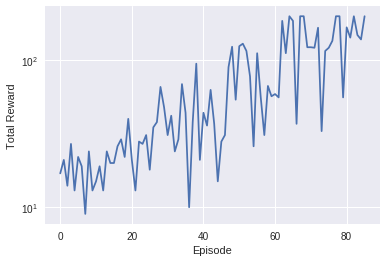

In [13]:
plt.plot(rewards_history[::5])
plt.yscale('log')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

# Applying to our Berater Environment

In [0]:
import numpy as np
import random

import gym
from gym.utils import seeding
from gym import spaces

def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]
    
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions: 
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    
    showStep = False
    showDone = True
    envEpisodeModulo = 100

    def __init__(self):
#         self.map = {
#             'S': [('A', 100), ('B', 400), ('C', 200 )],
#             'A': [('B', 250), ('C', 400), ('S', 100 )],
#             'B': [('A', 250), ('C', 250), ('S', 400 )],
#             'C': [('A', 400), ('B', 250), ('S', 200 )]
#         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200 )],
            'A': [('S', 300), ('B', 100), ('E', 100 ), ('D', 100 )],
            'B': [('S', 100), ('A', 100), ('C', 50 ), ('K', 200 )],
            'C': [('S', 200), ('B', 50), ('M', 100 ), ('L', 200 )],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)
      
        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                             high=high,
                                             dtype=np.float32)
        self.reward_range = (-1, 1)

        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.envReward = 0
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
          return paths[action]
        else:
          # sorry, no such action, stay where you are and pay a high penalty
          return (state, 1000)
      
    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)
        lastState = self.state
        customerReward = self.customer_reward[destination]
        reward = (customerReward - cost) / self.optimum

        self.state = destination
        self.customer_visited(destination)
        done = destination == 'S' and self.all_customers_visited()

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += reward
        self.stepCount += 1
        self.envReward += reward
        self.envStepCount += 1

        if self.showStep:
            print( "Episode: " + ("%4.0f  " % self.envEpisodeCount) + 
                   " Step: " + ("%4.0f  " % self.stepCount) + 
                   lastState + ' --' + str(action) + '-> ' + self.state + 
                   ' R=' + ("% 2.2f" % reward) + ' totalR=' + ("% 3.2f" % self.totalReward) + 
                   ' cost=' + ("%4.0f" % cost) + ' customerR=' + ("%4.0f" % customerReward) + ' optimum=' + ("%4.0f" % self.optimum)      
                   )

        if done and not self.isDone:
            self.envEpisodeCount += 1
            if BeraterEnv.showDone:
                episodes = BeraterEnv.envEpisodeModulo
                if (self.envEpisodeCount % BeraterEnv.envEpisodeModulo != 0):
                    episodes = self.envEpisodeCount % BeraterEnv.envEpisodeModulo
                print( "Done: " + 
                        ("episodes=%6.0f  " % self.envEpisodeCount) + 
                        ("avgSteps=%6.2f  " % (self.envStepCount/episodes)) + 
                        ("avgTotalReward=% 3.2f" % (self.envReward/episodes) )
                        )
                if (self.envEpisodeCount%BeraterEnv.envEpisodeModulo) == 0:
                    self.envReward = 0
                    self.envStepCount = 0

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}

        return observation, reward, done, info

    def getObservation(self, position):
        result = np.array([ position, 
                               self.getPathObservation(position, 0),
                               self.getPathObservation(position, 1),
                               self.getPathObservation(position, 2),
                               self.getPathObservation(position, 3)
                              ],
                             dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        source = int_to_state_name(position)
        paths = self.map[self.state]
        if path < len(paths):
          target, cost = paths[path]
          reward = self.customer_reward[target] 
          result = reward - cost
        else:
          result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

      
    def modulate_reward(self):
      number_of_customers = len(self.map) - 1
      number_per_consultant = int(number_of_customers/2)
#       number_per_consultant = int(number_of_customers/1.5)
      self.customer_reward = {
          'S': 0
      }
      for customer_nr in range(1, number_of_customers + 1):
        self.customer_reward[int_to_state_name(customer_nr)] = 0
      
      # every consultant only visits a few random customers
      samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
      key_list = list(self.customer_reward.keys())
      for sample in samples:
        self.customer_reward[key_list[sample]] = 1000

      
    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.modulate_reward()
        self.state = 'S'
        return self.getObservation(state_name_to_int(self.state))
      
    def render(self):
      print(self.customer_reward)

In [17]:
env = BeraterEnv()
print(env.reset())
print(env.customer_reward)

[    0.  -300.   900.   800. -1000.     0.     0.  1000.  1000.     0.
     0.     0.  1000.     0.     0.  1000.  1000.  1000.     0.]
{'S': 0, 'A': 0, 'B': 1000, 'C': 1000, 'D': 0, 'E': 0, 'F': 0, 'G': 1000, 'H': 0, 'K': 0, 'L': 1000, 'M': 1000, 'N': 1000, 'O': 0}


In [0]:
from copy import deepcopy
import json

class Baseline():

  def __init__(self, env, verbose=1):
    self.env = env
    self.verbose = verbose
    self.reset()

  def reset(self):
    self.map = self.env.map
    self.rewards = self.env.customer_reward.copy()
    
  def as_string(self, state):
    # reward/cost does not hurt, but is useless, path obsucres same state
    new_state = {
        'rewards': state['rewards'],
        'position': state['position']
    }
    return json.dumps(new_state, sort_keys=True)
  
  def is_goal(self, state):
    if state['position'] != 'S': return False
    for reward in state['rewards'].values():
      if reward != 0: return False
    return True
    

  def expand(self, state):
    states = []
    for position, cost in self.map[state['position']]:
      new_state = deepcopy(state)
      new_state['position'] = position
      new_state['rewards'][position] = 0
      reward = state['rewards'][position]
      new_state['reward'] += reward
      new_state['cost'] += cost
      new_state['path'].append(position)
      states.append(new_state)
    return states

  def search(self, root, max_depth = 25):
      closed = set()
      open = [root]

      while open:
          state = open.pop(0)
          if self.as_string(state) in closed: continue  

          closed.add(self.as_string(state))

          depth = len(state['path'])
          if depth > max_depth:
            if self.verbose > 0:
              print("Visited:", len(closed))
              print("Reached max depth, without reaching goal")
            return None

          if self.is_goal(state):
            scaled_reward = (state['reward'] - state['cost']) / 6000
            state['scaled_reward'] = scaled_reward
            if self.verbose > 0:
              print("Scaled reward:", scaled_reward)            
              print("Perfect path", state['path'])
            return state

          expanded = self.expand(state)
          open += expanded
          # make this best first
          open.sort(key=lambda state: state['cost'])
        
  def find_optimum(self):
    initial_state = {
        'rewards': self.rewards.copy(),
        'position': 'S',
        'reward': 0,
        'cost': 0,
        'path': ['S']
    }
    return self.search(initial_state)
  
  def benchmark(self, model, sample_runs=100):
    self.verbose = 0
    BeraterEnv.showStep = False
    BeraterEnv.showDone = False

    perfect_rewards = []
    model_rewards = []
    for run in range(sample_runs):
      observation = self.env.reset()
      self.reset()
      
      optimum_state = self.find_optimum()
      perfect_rewards.append(optimum_state['scaled_reward'])
      
      state = np.zeros((1, 2*128))
      dones = np.zeros((1))

      for t in range(1000):
        actions, _, state, _ = model.step(observation, S=state, M=dones)
        observation, reward, done, info = self.env.step(actions[0])
        if done:
          break
      model_rewards.append(env.totalReward)
    return perfect_rewards, model_rewards
  
  def score(self, model, sample_runs=100):
    perfect_rewards, model_rewards = self.benchmark(model, sample_runs=100)
    
    perfect_score_mean, perfect_score_std = np.array(perfect_rewards).mean(), np.array(perfect_rewards).std()
    test_score_mean, test_score_std = np.array(model_rewards).mean(), np.array(model_rewards).std()
    
    return perfect_score_mean, perfect_score_std, test_score_mean, test_score_std

In [0]:
class ProbabilityDistribution(tf.keras.Model):
    def call(self, logits):
        # sample a random categorical action from given logits
        return tf.squeeze(tf.random.categorical(logits, 1), axis=-1)

class Model(tf.keras.Model):
    def __init__(self, num_actions):
        super().__init__('mlp_policy')
        # Olli: add core here
        x = 
        self.core = kl.Dense(128, activation='relu')
        self.hidden1 = kl.Dense(128, activation='relu')
        self.hidden2 = kl.Dense(128, activation='relu')
        self.value = kl.Dense(1, name='value')
        # logits are unnormalized log probabilities
        self.logits = kl.Dense(num_actions, name='policy_logits')
        self.dist = ProbabilityDistribution()

    def call(self, inputs):
        # inputs is a numpy array, convert to Tensor
        x = tf.convert_to_tensor(inputs)
        # separate hidden layers from the same input tensor
        hidden_logs = self.hidden1(x)
        hidden_vals = self.hidden2(x)
        return self.logits(hidden_logs), self.value(hidden_vals)

    def action_value(self, obs):
        # executes call() under the hood
        logits, value = self.predict(obs)
        action = self.dist.predict(logits)
        # a simpler option, will become clear later why we don't use it
        # action = tf.random.categorical(logits, 1)
        return np.squeeze(action, axis=-1), np.squeeze(value, axis=-1)
      
class A2CAgent:
    def __init__(self, model):
        # hyperparameters for loss terms, gamma is the discount coefficient
        self.params = {
            'gamma': 1.0,# changeed
            'value': 0.5,
            'entropy': 0.05 # changeed
        }
        self.model = model
        self.model.compile(
            optimizer=ko.Adam(), # changeed
            # define separate losses for policy logits and value estimate
            loss=[self._logits_loss, self._value_loss]
        )
    
    def train(self, env, batch_sz=32, updates=1000):
        # storage helpers for a single batch of data
        actions = np.empty((batch_sz,), dtype=np.int32)
        rewards, dones, values = np.empty((3, batch_sz))
        observations = np.empty((batch_sz,) + env.observation_space.shape)
        # training loop: collect samples, send to optimizer, repeat updates times
        ep_rews = [0.0]
        next_obs = env.reset()
        for update in range(updates):
            for step in range(batch_sz):
                observations[step] = next_obs.copy()
                actions[step], values[step] = self.model.action_value(next_obs[None, :])
                next_obs, rewards[step], dones[step], _ = env.step(actions[step])

                ep_rews[-1] += rewards[step]
                if dones[step]:
                    ep_rews.append(0.0)
                    next_obs = env.reset()
                    logging.info("Episode: %03d, Reward: %03d" % (len(ep_rews)-1, ep_rews[-2]))

            _, next_value = self.model.action_value(next_obs[None, :])
            returns, advs = self._returns_advantages(rewards, dones, values, next_value)
            # a trick to input actions and advantages through same API
            acts_and_advs = np.concatenate([actions[:, None], advs[:, None]], axis=-1)
            # performs a full training step on the collected batch
            # note: no need to mess around with gradients, Keras API handles it
            losses = self.model.train_on_batch(observations, [acts_and_advs, returns])
            logging.debug("[%d/%d] Losses: %s" % (update+1, updates, losses))
        return ep_rews

    def test(self, env, render=False):
        obs, done, ep_reward = env.reset(), False, 0
        while not done:
            action, _ = self.model.action_value(obs[None, :])
            obs, reward, done, _ = env.step(action)
            ep_reward += reward
            if render:
                env.render()
        return ep_reward

    def _returns_advantages(self, rewards, dones, values, next_value):
        # next_value is the bootstrap value estimate of a future state (the critic)
        returns = np.append(np.zeros_like(rewards), next_value, axis=-1)
        # returns are calculated as discounted sum of future rewards
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.params['gamma'] * returns[t+1] * (1-dones[t])
        returns = returns[:-1]
        # advantages are returns - baseline, value estimates in our case
        advantages = returns - values
        return returns, advantages
    
    def _value_loss(self, returns, value):
        # value loss is typically MSE between value estimates and returns
        return self.params['value']*kls.mean_squared_error(returns, value)

    def _logits_loss(self, acts_and_advs, logits):
        # a trick to input actions and advantages through same API
        actions, advantages = tf.split(acts_and_advs, 2, axis=-1)
        # sparse categorical CE loss obj that supports sample_weight arg on call()
        # from_logits argument ensures transformation into normalized probabilities
        weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
        # policy loss is defined by policy gradients, weighted by advantages
        # note: we only calculate the loss on the actions we've actually taken
        actions = tf.cast(actions, tf.int32)
        policy_loss = weighted_sparse_ce(actions, logits, sample_weight=advantages)
        # entropy loss can be calculated via CE over itself
        entropy_loss = kls.categorical_crossentropy(logits, logits, from_logits=True)
        # here signs are flipped because optimizer minimizes
        return policy_loss - self.params['entropy']*entropy_loss      

In [0]:
model = Model(num_actions=env.action_space.n)
agent = A2CAgent(model)

In [61]:
%%time
# set to logging.WARNING to disable logs or logging.DEBUG to see losses as well
logging.getLogger().setLevel(logging.WARNING)

rewards_history = agent.train(env, updates=10000)
rewards_history

Done: episodes=    57  avgSteps=8125.60  avgTotalReward=-564.18
Done: episodes=    58  avgSteps=8068.48  avgTotalReward=-562.91
Done: episodes=    59  avgSteps=8230.92  avgTotalReward=-581.64
Done: episodes=    60  avgSteps=8279.12  avgTotalReward=-586.61
Done: episodes=    61  avgSteps=8286.16  avgTotalReward=-591.65
Done: episodes=    62  avgSteps=8313.02  avgTotalReward=-594.24
Done: episodes=    63  avgSteps=8195.81  avgTotalReward=-585.90
Done: episodes=    64  avgSteps=8079.73  avgTotalReward=-578.41
Done: episodes=    65  avgSteps=8011.48  avgTotalReward=-573.51
Done: episodes=    66  avgSteps=7929.38  avgTotalReward=-568.32
Done: episodes=    67  avgSteps=7850.70  avgTotalReward=-564.81
Done: episodes=    68  avgSteps=7815.82  avgTotalReward=-562.66
Done: episodes=    69  avgSteps=7888.99  avgTotalReward=-564.58
Done: episodes=    70  avgSteps=7801.69  avgTotalReward=-559.07
Done: episodes=    71  avgSteps=7900.90  avgTotalReward=-565.67
Done: episodes=    72  avgSteps=7841.64 

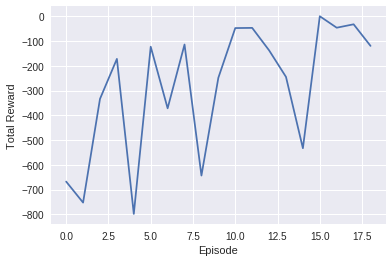

In [72]:
# plt.plot(rewards_history)
plt.plot(rewards_history[::5])
# plt.yscale('log')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()